## Introduction

A study by <a href="https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=1117&context=soe_research">Phang and Wong (1997)</a>, suggests that government regulations and interventions, rather than macroeconomic factors, have a significant influence on Singapore's property market. The government has implemented multiple waves of cooling measures since 1996, including policies such as Buyer's Stamp Duty, Loan-to-Value Ratio, Loan Tenure, and Wait-Out periods. These measures aim to curb excessive speculation and promote owner-occupation for residential homes, ensuring a sustainable market.

Since the onset of the COVID-19 pandemic, Singapore's property market has experienced rapid growth, with a 14% year-on-year increase in January 2023, as reported by third-quarter data from Knight Frank. In response, the government introduced new cooling measures in September 2022 to prevent overheating, and on 26th April 2023, new measures were announced, with expected impact on the property market, especially for foreigners. Therefore, a thorough understanding of government policies and their impact on the property market is critical for forecasting property prices.

This EDA aims to examine the components of government policies and their impact on property prices, providing insight into how the changing measures may affect the property market.

First, lets understand the key components of the cooling measures. 

#### BSD and ABSD

<u>Buyer's Stamp Duty (BSD)</u> - This is a tax levied on buyers who purchase any property in Singapore. It is a progressive tax rate that increases with the property price. The current rates for residential properties are 1% for the first SGD180k, 2% for the next SGD180k, 3% for the next SGD640K, and so on. 

<u>Additional Buyer's Stamp Duty (ABSD)</u> - This is an additional tax imposed on top of the BSD for certain categories of buyers, typically for Singaporeans buying their second property or for Permanent Residents buying their first property. ABSD rates vary depending on the buyer's profile and the property type. The purpose of ABSD is to discourage property speculation and curb demand from foreign buyers. Following the latest policy, a Singapore citizen purchasing a second residential property would be subject to a 20% ABSD, while a foreigner purchasing any residential property would be subject to a 60% ABSD, up from the previous 30%.

#### Loan-to-Value (LTV) Ratio

The <u>Loan-to-Value (LTV)</u> Ratio is the maximum percentage of the property's value that can be financed by a bank loan. The LTV Ratio limits the amount of debt that buyers can take on, thereby reducing the risk of default and ensuring that buyers can afford the property. By imposing a lower LTV ratio, the government aims to discourage buyers from taking on excessive debt and reduce the risk of a property bubble. The current LTV stands at 80% for HDB loans (applicable for only public housing) and 75% for bank loans.

#### Loan Tenure

The <u>Loan Tenure</u> is the maximum number of years that a buyer can take to repay their bank loan. The loan tenure limits the amount of interest that buyers need to pay and affects the affordability of the property. By imposing a shorter loan tenure, the government aims to encourage buyers to pay off their loans faster and reduce the risk of default. The current loan tenure stands at 30 years for HDB flats and 35 years for non-HDB properties, up to an age of 65. 

#### Total Debt Servicing Ratio (TDSR)

<u>TDSR</u> stands for Total Debt Servicing Ratio. It is a framework introduced by the Monetary Authority of Singapore (MAS) in June 2013 to help financial institutions ensure that borrowers do not become overleveraged by capping the amount they can borrow based on their income and debt obligations. Under the TDSR framework, the total amount of debt obligations (including mortgage payments) that a borrower has should not exceed 55% of their gross monthly income.

#### Wait-Out Period

The <u>Wait-Out Period</u> is the minimum number of years that buyers have to hold their property before they can sell it without paying additional taxes. By imposing a wait-out period, the government aims to discourage short-term speculation and encourage owner-occupation. This rule was newly introduced on 30th Sep 2022 and it stipulates that private residential property owners (PPOs) and ex-PPOs are required to serve a wait-out period of 15 months after the disposal of their private properties before they are eligible to buy a public residential flat (HDB).

## Data Preprocessing

In [1]:
import re
import pandas as pd
import numpy as np
import os

from toolz import *
from toolz.curried import *

import matplotlib.pyplot as plt
import seaborn as sns

Process the dataframes based on <a href="https://datameka.com/competition/9389d2dc-5cfe-41d5-b057-ada6500ebb15?tabIndex=2">Jacob's baseline code</a>

In [2]:
# set default path
os.chdir(r'C:\Users\HousingPrice')

# paths to all the csvs files provided in the challenge.
trainPath   = "train.csv"
testPath    = "test.csv" 
microPath   = "properties.csv"
geoPath     = "geo_attributes.csv"

## load train&test_keys that contain unique identifier for each observation
train_keys = pd.read_csv(trainPath).assign(train = 1)
test_keys  = pd.read_csv(testPath).assign(train = 0).assign(price = pd.NA)
keys       = pd.concat([train_keys, test_keys])
keys       = keys.rename(columns = {"contractDate" : "date"})

## merge key with micro to borrow the date information in key.
_micro = pd.read_csv(microPath)
micro  = pd.merge(_micro, keys, on = "property_key")

# load geo
geo = pd.read_csv(geoPath)

In [3]:
def preprocess_micro(micro):    
    """
    preprocess micro data properties.csv
    """
    def _floorRange(row, thresFloor = 41):
        """
        some floorRanges are too rare to be used as categorical variables
        Hence merging floorRage above the "thresFloor" into one.
        """
        floorRange = row["floorRange"]    
        if floorRange != "-":
            floorMin = int(re.search("(\d+)-", floorRange).groups()[0])
            if floorMin >= thresFloor:
                row["floorRange"] = f"{thresFloor}-99"    
        return row

    def _tenure(row):
        """
        some tenures are too rare to be used as variables.
        Hence simply making tenure feature to 1 if freehold else 0.
        """
        tenure = row["tenure"]    
        if tenure == "Freehold" : row["tenure"] = 1
        else                    : row["tenure"] = 0        
        return row
        
    micro = (micro
             .apply(_floorRange, axis = 1)
             .apply(_tenure, axis = 1))
    
    micro["date"] = pd.to_datetime(micro["date"])
    
    return micro

micro = preprocess_micro(micro)

In [4]:
# delete 'district' and 'project' columns from geo dataframe
del geo['district']
del geo['project']

# merge geo and micro dataframes on 'street' column and assign to merged_df variable
df = pd.merge(geo, micro, on='street', how='left')

# Remove rows with missing lat and lng values
df = df.dropna(subset=['lat', 'lng', 'price'])

## Overview of Impact of Government Policies

The bar chart below provides a comprehensive overview of the average price per square foot (PSF) changes in the housing market over the dataset. The highlighted red months indicate when cooling measures were implemented. During the period, there were three cooling measures introduced, two of which were implemented during the Covid-19 pandemic. These measures primarily involved increasing the tiers of Additional Buyer's Stamp Duty (ABSD), tightening Total Debt Servicing Ratio (TDSR) ratios, reducing Loan-To-Value (LTV) limits, and introducing wait-out periods.

As a result of these cooling measures, the affordability of housing for investors who purchased solely for speculation purposes decreased. The short-term effect of these policies was a decline in housing prices. The most significant impact was observed in July 2018, where prices experienced a sharp decline in the months following the implementation of cooling measures. However, the effectiveness of the subsequent two cooling measures was reduced, and the market was not deterred by the measures, leading to an upward trend in housing prices.

It's important to note that the effectiveness of these measures may be influenced by various factors, such as market sentiment, economic conditions, and government policies. The housing market is a complex system influenced by several factors, including but not limited to, positive market speculation and macroeconomic forces. Hence, predicting the impact of cooling measures on the housing market is challenging. Additionally, the later two cooling measures were targeted at reducing overheating in the resale HDB market and had limited impact on private property prices.

#### Cooling measures introduced in Jul 2018 
 - Increased ABSD rates

|                                    | Rates on or before 5 July 2018 | Rates on or after 6 July 2018 |
|:-----------------------------------|:-------------------------------|:-------------------------------|
| SCs buying first residential property | 0%                           | 0%                           |
|                                    | (No change)                  | (No change)                  |
| SCs buying second residential property | 7%                           | 12%                          |
|                                    | (Revised)                    | (Revised)                    |
| SCs buying third and subsequent residential property | 10%                     | 15%                          |
|                                    | (Revised)                    | (Revised)                    |
| SPRs buying first residential property | 5%                           | 5%                           |
|                                    | (No change)                  | (No change)                  |
| SPRs buying second and subsequent residential property | 10%                     | 15%                          |
|                                    | (Revised)                    | (Revised)                    |
| Foreigners buying any residential property | 15%                     | 20%                          |
|                                    | (Revised)                    | (Revised)                    |
| Entities buying any residential property | 15%                        | 25%                          |
|                                    | (Revised)                    | (Revised)                    |

- Reduced LTV limits

|                          | 1st Housing Loan | 2nd Housing Loan | From 3rd Housing Loan |
|--------------------------|-----------------|-----------------|----------------------|
| Individual Borrowers     |                  |                  |                       |
| LTV Limit                |                 |                 |                       |
| Existing Rules           | 80%; or 60% if the loan tenure is more than 30 years* or extends past age 65 | 50%; or 30% if the loan tenure is more than 30 years* or extends past age 65 | 40%; or 20% if the loan tenure is more than 30 years* or extends past age 65 |
| Revised Rules            | 75%; or 55% if the loan tenure is more than 30 years* or extends past age 65 | 45%; or 25% if the loan tenure is more than 30 years* or extends past age 65 | 35%; or 15% if the loan tenure is more than 30 years* or extends past age 65 |
| Minimum Cash Down Payment| No change to existing rules | 5%; or 10% if the loan tenure is more than 30 years* or extends past age 65 | 25% |
| Non-Individual Borrowers |                  |                  |                       |
| LTV Limit                |                  |                  |                       |
| Existing Rule            | 20%             | 20%             | 20%                  |
| Revised Rule             | 15%             | 15%             | 15%                  |


#### Cooling measures introduced in Dec 2021
- Increased ABSD

|                                    | Rates on or before 16 Dec 2021 | Rates on or after16 Dec 2021 |
|:-----------------------------------|:-------------------------------|:-------------------------------|
| SCs buying first residential property | 0%                           | 0%                           |
|                                    | (No change)                  | (No change)                  |
| SCs buying second residential property | 12%                           | 17%                          |
|                                    | (Revised)                    | (Revised)                    |
| SCs buying third and subsequent residential property | 15%                     | 25%                          |
|                                    | (Revised)                    | (Revised)                    |
| SPRs buying first residential property | 5%                           | 5%                           |
|                                    | (No change)                  | (No change)                  |
| SPRs buying second and subsequent residential property | 15%                     | 25%/30% (3rd and subsequent)                          |
|                                    | (Revised)                    | (Revised)                    |
| Foreigners buying any residential property | 20%                     | 30%                          |
|                                    | (Revised)                    | (Revised)                    |
| Entities buying any residential property | 25%                        | 35%                          |
|                                    | (Revised)                    | (Revised)                    |

- Reduced LTV limits: 90% to 85% for public housing loans
- Tighter TDSR threshold from 65% to 60%

#### Cooling measures introduced in Sep, 2022
- Reduced LTV limits: 85% to 80% for public housing loans
- Increased TDSR
- 15 months wait out period for private to public housing downgrading 

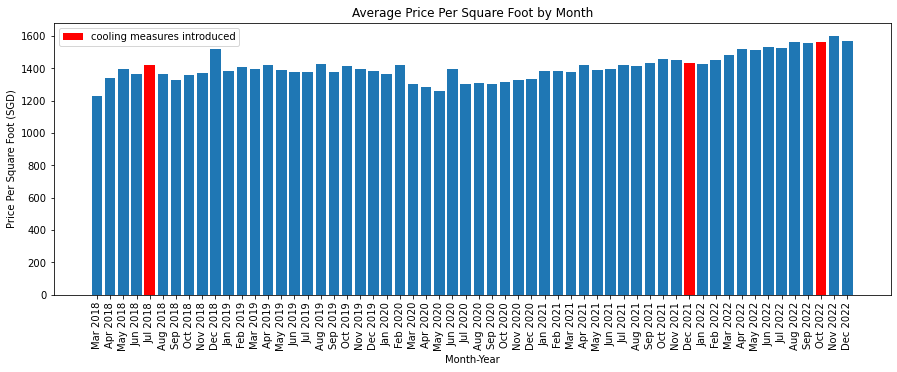

In [5]:
# convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# get price per square feet
df['price_psf'] = df['price'] / (df['area']*10.7639)

# group by year and month, calculate the average price_psf
monthly_avg = df.groupby([df['date'].dt.year.rename('year'), df['date'].dt.month.rename('month')])['price_psf'].mean().reset_index()

# create a new column for month-year label
monthly_avg['month_year'] = monthly_avg.apply(lambda x: pd.Timestamp(year=int(x['year']), month=int(x['month']), day=1).strftime('%b %Y'), axis=1)

# create the bar chart
plt.figure(figsize=(15,5))
plt.bar(monthly_avg['month_year'], monthly_avg['price_psf'])

# add title and axis labels
plt.title('Average Price Per Square Foot by Month')
plt.xlabel('Month-Year')
plt.ylabel('Price Per Square Foot (SGD)')

# rotate x-axis labels
plt.xticks(rotation=90)

# highlight bars for Jul 2018 and Oct 2019
highlight_indices = monthly_avg.index[(monthly_avg['month_year'] == 'Jul 2018') | (monthly_avg['month_year'] == 'Oct 2022') | (monthly_avg['month_year'] == 'Dec 2021') ]
plt.bar(monthly_avg.loc[highlight_indices, 'month_year'], monthly_avg.loc[highlight_indices, 'price_psf'], color='red', label='cooling measures introduced')

# add legend for highlighted bar
plt.legend()

plt.show()

## Implications for Housing Price Forecast

Government policies play a significant role in regulating the Singapore property market and can have significant implications on the forecast of future prices. To improve the accuracy of predictions, additional features can be created based on government policies, such as:
- the introduction timing of the cooling measures
- changes in tax policies (ABSD) and loan ratio (LTV, TDSR)
- government land sales programs

However, take note that predicting when the government will introduce cooling measures to regulate the market can be challenging as it is influenced by various factors such as market sentiment, economic conditions, and global events.

It is important to keep track of any upcoming policies based on price trends, as these policies can have a significant impact on the property market. For example, if prices continue to rise rapidly, the government may introduce measures to cool the market, which may result in a decline in prices in the short term. Conversely, if prices remain stable or decline, the government may introduce policies to stimulate demand and stabilize prices.

Overall, understanding the implications of government policies on the property market is crucial for accurately forecasting future prices. This involves keeping track of policy changes, predicting when cooling measures may be introduced, and identifying any upcoming policies that may impact the market.